**Brain Stroke Prediction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import imblearn
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
#metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from numpy import mean
from scipy.stats import uniform
from scipy import interp
from sklearn.utils import class_weight

In [2]:
df=pd.read_csv("/content/brain_stroke.csv")
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [3]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [4]:
obj = (df.dtypes == 'object')
print("Categorical variables:",len(list(obj[obj].index)))


Categorical variables: 5


In [5]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

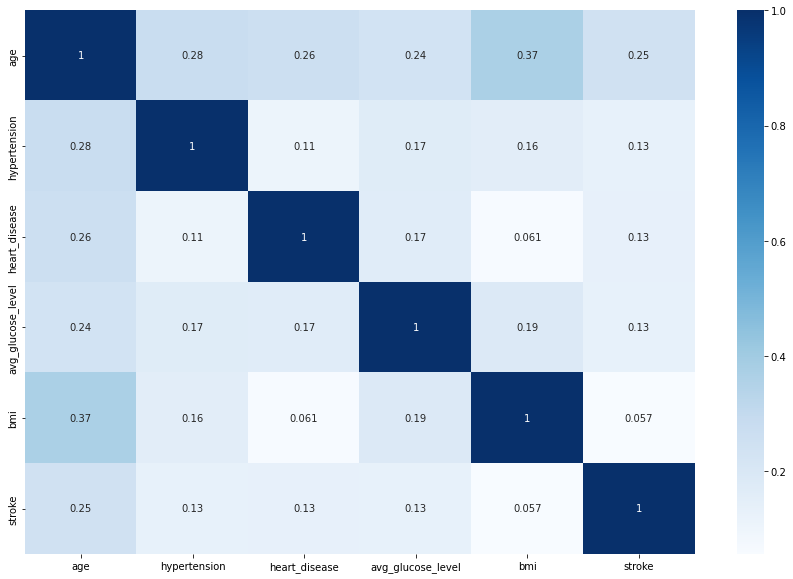

In [6]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.corr(), annot = True, cmap = 'Blues')

In [7]:
df.shape

(4981, 11)

In [8]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [9]:
df['gender'] = df['gender'].map({'Female':1,'Male':0})
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['work_type'] = df['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job':2, 'children':3})
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural':0})
df['smoking_status'] = df['smoking_status'].map({'formerly smoked':0, 'never smoked':1, 'smokes':2, 'Unknown':3})

In [10]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,1,228.69,36.6,0,1
1,0,80.0,0,1,1,0,0,105.92,32.5,1,1
2,1,49.0,0,0,1,0,1,171.23,34.4,2,1
3,1,79.0,1,0,1,1,0,174.12,24.0,1,1
4,0,81.0,0,0,1,0,1,186.21,29.0,0,1


In [11]:
X = df.iloc[:,:-1].values
y = df['stroke'].values

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [13]:
from sklearn.preprocessing import MinMaxScaler

scale=MinMaxScaler()
X_scaled=pd.DataFrame(scale.fit_transform(X_train))
X_scaled

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.316406,0.0,0.0,0.0,0.000000,1.0,0.531556,0.255014,0.333333
1,1.0,0.328613,0.0,0.0,1.0,0.000000,1.0,0.119686,0.739255,0.666667
2,0.0,0.658203,0.0,0.0,1.0,0.666667,0.0,0.153922,0.489971,0.666667
3,1.0,0.023438,0.0,0.0,0.0,1.000000,0.0,0.174850,0.022923,1.000000
4,1.0,0.841309,1.0,0.0,1.0,0.000000,0.0,0.270739,0.558739,0.000000
...,...,...,...,...,...,...,...,...,...,...
3979,1.0,0.658203,0.0,0.0,1.0,0.666667,1.0,0.829665,0.455587,0.333333
3980,1.0,0.462891,0.0,0.0,1.0,0.666667,1.0,0.074304,0.790831,0.333333
3981,0.0,0.157715,0.0,0.0,0.0,0.000000,0.0,0.166855,0.083095,0.333333
3982,1.0,0.004883,0.0,0.0,0.0,1.000000,0.0,0.299238,0.097421,1.000000


In [14]:
df['stroke'].value_counts()

0    4733
1     248
Name: stroke, dtype: int64

In [15]:
y.shape

(4981,)

In [16]:
model_1 = LogisticRegression(class_weight = 'balanced')

model_1.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight='balanced')

In [17]:
predictions_1 = model_1.predict(X_test)

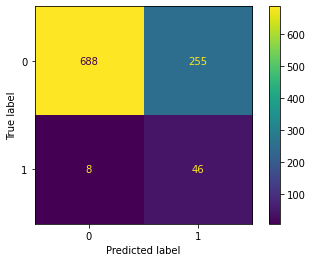

In [18]:
cm= confusion_matrix(y_test, predictions_1, labels = model_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_1.classes_)
disp.plot()

In [19]:
clf_report = classification_report(y_test, predictions_1)
print(clf_report)

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       943
           1       0.15      0.85      0.26        54

    accuracy                           0.74       997
   macro avg       0.57      0.79      0.55       997
weighted avg       0.94      0.74      0.81       997



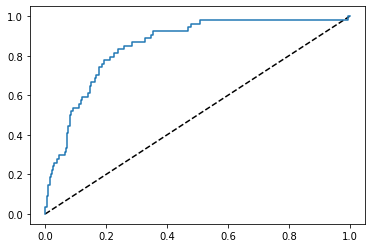

In [20]:
y_pred_prob = model_1.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.show()

In [21]:
auc = metrics.roc_auc_score(y_test, y_pred_prob)
auc

0.85306940025922

In [22]:
# Conclusion
# Logistic Regression Classifier did better Classification since, they seem to most likely overfit.